3D AugmentedReality Course Project

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
from sklearn.metrics import confusion_matrix,accuracy_score
from skimage.transform import rescale, resize, downscale_local_mean
import binvox_rw
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import plotly
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from tqdm import tqdm
import h5py
import pandas as pd

#external libraries written by me for this notebook
from extraction_performances import extraction_performances
from IAHOS import IAHOS
from hyperparams_initialization import hyperparams_initialization
#libraries of Keras for the neural networks
import keras
from keras import backend as K
from keras.models import Sequential,Input,Model
from keras.layers import Conv3D,MaxPooling3D,Dense,Flatten,Dropout
from keras import initializers,optimizers,backend as k
from keras.callbacks import EarlyStopping,ModelCheckpoint
from time import time

Using TensorFlow backend.


In [ ]:
data = pd.read_csv("all.csv") 
print (data)

In [ ]:
classes = ['airplane','bin','bag','basket','bathtub','bed','bench','bird house','library',
          'bottle','bowl','bus','dresser','camera','can','cap','car','smartphone','chair',
          'clock','keyboard','dishwashers','display','headphones','faucet','library',
          'guitar','helmet','jar','knife','lamp','laptop','loudspeaker','mail box','unknown',
          'microwave','motorbike','cup','piano','pillow','pistol','plant','scanner','telecontrol',
          'rifle','rocket','skate','sofa','oven','table','smartphone','tower','railway engine',
          'ship','washing machine']
np.save('classes',classes)

In [ ]:
#study of the original dataset situation
lengths=[]
categories = os.listdir('G:\ShapeNetCore.v2')#total number of classes
for i in tqdm(range(len(categories))):#for all the classe I use all models
    model = os.listdir('G:\ShapeNetCore.v2/'+categories[i])
    l=0
    for j in range(len(model)):
            try:
                with open('G:\ShapeNetCore.v2/'+categories[i]+'/'+model[j]+'/models/'+'model_normalized.surface.binvox', 'rb') as f:
                    surface = binvox_rw.read_as_coord_array(f)
                    l+=1
            except:
                pass
    lengths.append(l)

plt.figure(figsize=(10,4))
plt.bar(classes,lengths)
plt.title('Models per class distribution')
plt.xlabel('Class')
plt.ylabel('Models')
plt.xticks(rotation=90)
plt.show()

In [ ]:
dataset_voxels=[]
dataset_1face = []
dataset_2faces = []
dataset_3faces = []
dataset_4faces = []
dataset_5faces = []
dataset_6faces = []
models_number=min(lengths)
insert = False
for i in tqdm(range(len(categories))):
    model = os.listdir('G:\ShapeNetCore.v2/'+categories[i])
    l=0
    for j in range(len(model)):
        if l<models_number:
            try:
                with open('G:\ShapeNetCore.v2/'+categories[i]+'/'+model[j]+'/models/'+'model_normalized.surface.binvox', 'rb') as f:
                    surface = binvox_rw.read_as_coord_array(f)
                    if insert==True:
                        Volume = np.zeros((128,128,128))
                        for k in range(len(surface.data[0])):
                            x = surface.data[0][k]
                            y = surface.data[1][k]
                            z = surface.data[2][k]
                            Volume[x,y,z]=1
                        Volume_resized = resize(Volume, (32,32,32),anti_aliasing=True)
                        dataset.append(Volume_resized)
                    l+=1
            except:
                pass
    lengths.append(l)

training_samples = 55*56
labels = np.zeros((training_samples,55))
for i in range(training_samples):
    j=int(i/56)
    labels[i,j]=1
np.save('labels',labels)   

Plot a model (at random from the dataset)

In [ ]:
x=surface.data[0]
y=surface.data[1]
z=surface.data[2]
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,mode='markers',
                      marker=dict(size=1,color=z,colorscale='hot',opacity=0.5))])
fig.update_layout(width=800,height=400,autosize=True)
fig.show()

Neural Networks

Part A of the Project - Classification of 3D models

In [2]:
#Load dataset from disk
classes = np.load('classes.npy')
labels = np.load('labels.npy')
hf = h5py.File('data32.h5', 'r')
n1 = hf.get('dataset_1')
n1 = np.array(n1)
hf.close()
randomize = np.arange(len(n1))
np.random.shuffle(randomize)
n1=n1[randomize]
labels=labels[randomize]
index1 = int(len(n1)*0.7)
index2 = int(len(n1)*0.1)
training_set = n1[0:index1].reshape((-1,32,32,32,1))
training_labels=labels[0:index1]
validation_set = n1[index1:index1+index2].reshape((-1,32,32,32,1))
validation_labels=labels[index1:index1+index2]
test_set = n1[index1+index2:].reshape((-1,32,32,32,1))
test_labels=labels[index1+index2:]
del n1,hf

In [3]:
def Classifier(input_size,i,hm,optimizer):
    x = Input(shape=(input_size,input_size,input_size,1))
    x1 = (Conv3D(int(hm[0,i]),kernel_size=(int(hm[1,i]),int(hm[1,i]),int(hm[1,i])),activation='relu'))(x)
    x1 = (MaxPooling3D(pool_size=(int(hm[2,i]),int(hm[2,i]),int(hm[2,i])),
                       strides=(int(hm[3,i]),int(hm[3,i]),int(hm[3,i]))))(x1)
    for j in range(int(hm[4,i])):
        x1 = (Conv3D(int(hm[5,i]),kernel_size=(int(hm[6,i]),int(hm[6,i]),int(hm[6,i])),activation='relu'))(x1)
    y1 = Flatten()(x1)
    y2 = (Dense(int(hm[7,i]),activation='relu'))(y1)
    y2 = Dropout(hm[8,i])(y2)
    y = (Dense(55,activation='softmax'))(y2)
    classifier=Model(inputs=x,outputs=y)
    classifier.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return classifier

In [4]:
attempts=2
variables=9
iterations=attempts**variables
limits = [[4,16],[2,4],[2,3],[1,2],[0,2],[4,16],[2,4],[55,200],[0,0.5]]
method='grid'
rounds=2

In [ ]:
tgp,tgp2,ogp,ogp2,final=IAHOS(rounds,method,limits,attempts,variables,iterations,Classifier,
                       training_set,training_labels,validation_set,validation_labels)
np.save('final',final)

In [ ]:
fig = make_subplots(rows=2, cols=2,subplot_titles=("Mean train. accuracy first round",
                                                   "Mean valid accuracy first round",
                                                  "Mean train accuracy last round",
                                                  "Mean valid accuracy last round"))
y = ['#filter1','kernel1','maxpool1','stride_pool','#layers',
     '#filter2','kernel2','fully_dim','dropout']
x = np.linspace(0,len(tgp[0])-1,len(tgp[0]))
Colorscale = [[0, '#FF0000'],[0.5, '#F1C40F'], [1, '#00FF00']]
fig.add_trace(go.Heatmap(y=[y[i] for i in range(len(y))],
                   x=[0,1],
                   z=ogp2, colorscale = Colorscale),row=1,col=1)
fig.add_trace(go.Heatmap(y=[y[i] for i in range(len(y))],
                   x=[0,1],
                   z=ogp,colorscale=Colorscale),row=1,col=2)
fig.add_trace(go.Heatmap(y=[y[i] for i in range(len(y))],
                   x=x,
                   z=tgp2, colorscale = Colorscale),row=2,col=1)
fig.add_trace(go.Heatmap(y=[y[i] for i in range(len(y))],
                   x=x,
                   z=tgp,colorscale=Colorscale),row=2,col=2)
fig.update_layout(height=600, width=800)

fig.show()

In [8]:
final = np.load('final.npy')
best_hp = np.zeros((variables,1))
for i in range(variables):
    best_hp[i]=final[i]
l=0
epochs=3
training_accuracy=[]
validation_accuracy=[]
test_scores=[]
optimizers = ['sgd','rmsprop','adagrad','adadelta','adam','adamax','nadam']
classifier=Classifier(32,0,best_hp,optimizers[0])
print (classifier.summary())

j=0
for optimizer in tqdm(optimizers):   
    early_stopping = EarlyStopping(monitor='val_acc',mode='max',min_delta=0,verbose=2,patience=epochs)
    mc = ModelCheckpoint('best_model_'+str(l)+'.h5', monitor='val_acc', mode='max',
                     verbose=2,save_best_only=True,period=epochs)
    classifier=Classifier(32,0,best_hp,optimizer)
    history=classifier.fit(training_set,training_labels,validation_data=[validation_set,validation_labels],
                           epochs=epochs,batch_size=20,verbose=0,callbacks=[mc])
    
    training_accuracy.append(history.history['acc'])
    validation_accuracy.append(history.history['val_acc'])
    print (mc.epochs_since_last_save)
    j+=1
    if j<6:
        del classifier,history,mc,early_stopping
        K.clear_session()
    l+=1
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 32, 1)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 31, 31, 31, 12)    108       
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 30, 30, 30, 12)    0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 324000)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 151)               48924151  
_________________________________________________________________
dropout_2 (Dropout)          (None, 151)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 55)                8360      
Total para



  0%|                                                                                            | 0/7 [00:00<?, ?it/s]


Epoch 00003: val_acc improved from -inf to 0.98182, saving model to best_model_0.h5
0




 14%|████████████                                                                        | 1/7 [00:18<01:49, 18.19s/it]


Epoch 00003: val_acc improved from -inf to 0.98849, saving model to best_model_1.h5
0




 29%|████████████████████████                                                            | 2/7 [00:42<01:40, 20.02s/it]


Epoch 00003: val_acc improved from -inf to 0.98867, saving model to best_model_2.h5
0




 43%|████████████████████████████████████                                                | 3/7 [01:04<01:22, 20.63s/it]


Epoch 00003: val_acc improved from -inf to 0.98719, saving model to best_model_3.h5
0




 57%|████████████████████████████████████████████████                                    | 4/7 [01:37<01:13, 24.36s/it]


Epoch 00003: val_acc improved from -inf to 0.98819, saving model to best_model_4.h5
0




 71%|████████████████████████████████████████████████████████████                        | 5/7 [02:05<00:50, 25.39s/it]


Epoch 00003: val_acc improved from -inf to 0.98872, saving model to best_model_5.h5
0




 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [02:30<00:25, 25.18s/it]


Epoch 00003: val_acc improved from -inf to 0.98784, saving model to best_model_6.h5
0




100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:04<00:00, 28.10s/it]

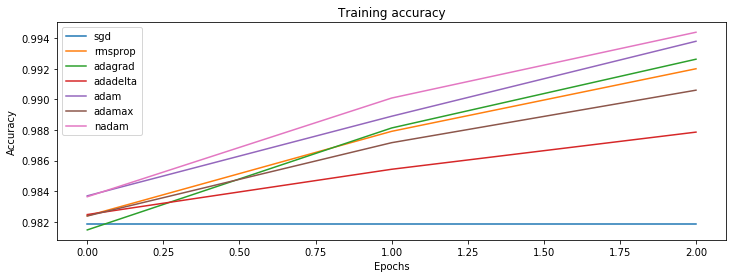

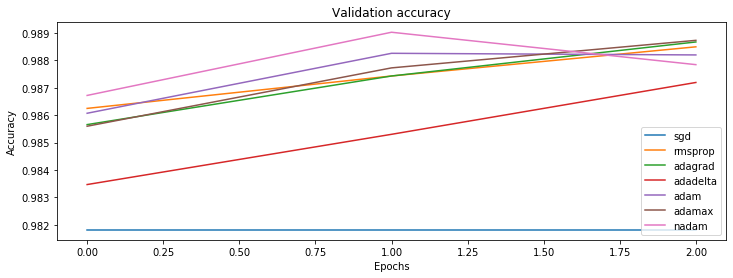

val_acc


In [9]:
plt.figure(figsize=(12,4))
for i in range(len(optimizers)):
    plt.plot(training_accuracy[i]) 
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(optimizers)
plt.show()

plt.figure(figsize=(12,4))
for i in range(len(optimizers)):
    plt.plot(validation_accuracy[i]) 
plt.title('Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(optimizers)
plt.show()
print (early_stopping.monitor)

Confusion matrix

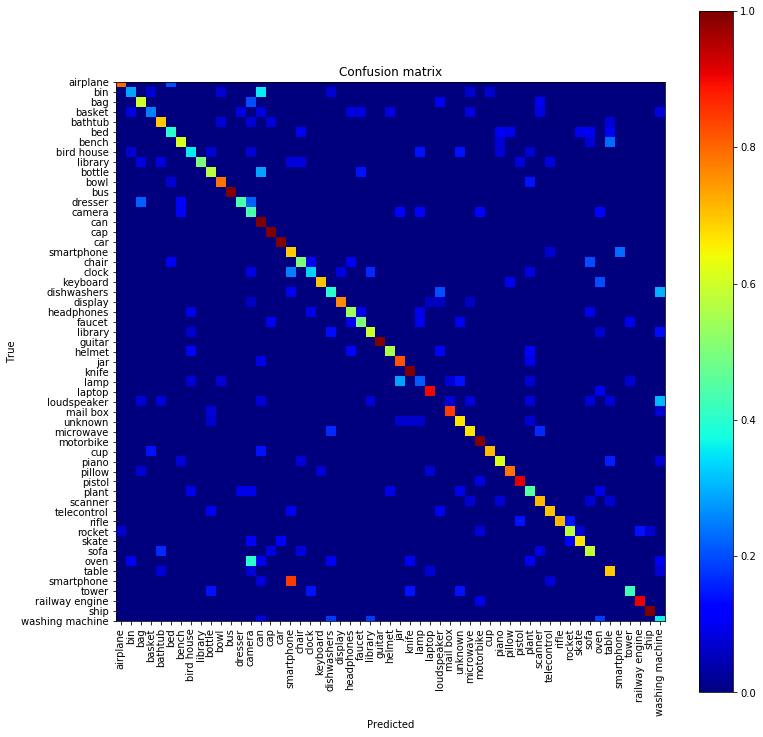

In [13]:
predictions = classifier.predict(test_set)
new_test_labels = np.zeros(test_labels.shape[0])
for i in range(test_labels.shape[0]):
    new_test_labels[i]=np.argmax(test_labels[i])
y_pred = np.zeros(test_labels.shape[0])
for i in range(test_labels.shape[0]):
    y_pred[i]=np.argmax(predictions[i])
cm = confusion_matrix(y_true=new_test_labels,y_pred=y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10,10))
plt.imshow(cm,interpolation='nearest',cmap=plt.cm.jet)
plt.tight_layout()
plt.colorbar()
tick_marks = np.arange(55)
plt.xticks(tick_marks,classes,rotation=90)
plt.yticks(tick_marks,classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()

In [ ]:
#here a random sample from test set is chosen and feeded to the NN, plotted its 3D model 
#and the resultin probability distribution

Part B of the Project - Comparison between Convolutions in 3D and in 2D

Part C of the Project - Use of GAN to create 3D models from 2D images